# Prelim

## Single Cell Analysis Environment Setup

Follow the steps below to set up a Conda environment for single-cell analysis:

1. **Create a new conda environment named "singlecell"** with necessary packages. We use the `bioconda` and `conda-forge` channels to find packages that are not available in the default channel:

    ```bash
    conda create --name singlecell -y -c bioconda -c conda-forge scanpy scrublet leidenalg python-igraph jupyterlab ipykernel fa2 ipywidgets
    ```

2. **Activate the "singlecell" environment**. You'll need to do this each time you start a new terminal session before installing new packages:

    ```bash
    conda activate singlecell
    ```

3. **Install additional Python packages** that are not available through Conda. We use `pip`, the Python package installer:

    ```bash
    pip install --upgrade scanpy 'git+https://github.com/dpeerlab/Harmony' cellxgene pyranges palantir
    ```

4. **Register the "singlecell" environment with Jupyter**. This allows you to use the environment in Jupyter notebooks:

    ```bash
    python -m ipykernel install --user --name $CONDA_DEFAULT_ENV --display-name "$CONDA_DEFAULT_ENV"
    ```

That's all! You've now set up your single cell analysis environment. Start a Jupyter notebook server by typing `jupyter-lab` into your terminal and begin your analysis. Remember to select the kernel `singlecell` within Jupyter for your analyses.

This primer will use a dataset provided by 10X: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3?

The raw and processed data will be downloaded to the `data/` folder.
1. [Raw data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5)
2. [Processed data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad)

# Imports

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import warnings

In [3]:
import palantir
import phenograph
import harmony

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# Ensure that plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Set the default figure size to 4x4 inches
matplotlib.rcParams["figure.figsize"] = [4, 4]

# Set the default figure resolution to 100 dots per inch
matplotlib.rcParams["figure.dpi"] = 100

# Set the default colormap to 'Spectral_r'
matplotlib.rcParams["image.cmap"] = "Spectral_r"

# Remove bounding boxes and axis
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.left'] = False
matplotlib.rcParams['axes.spines.right'] = False

# Suppress a specific warning from the 'scanpy' module
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy", lineno=392)

# Utility functions

In [6]:
from joblib import Parallel, delayed
from scipy.sparse import hstack
import gc

def log_transform(ad, ps=0.1):
    """
    Applies a pseudo-count log2 transformation to the data in an AnnData object.
    
    The transformation is defined as log2(x + ps) - log2(ps), where x is the original data
    and ps is the pseudo-count. The purpose of the pseudo-count is to avoid taking the log of zero.
    
    Parameters
    ----------
    ad: AnnData
        The AnnData object containing the data to be transformed.
        
    ps: float, optional
        The pseudo-count to be added to the data before taking the logarithm.
        The default value is 0.1.
        
    Returns
    -------
    None
        The function modifies the AnnData object in-place.
    """
    
    # Check if the data in the Anndata object is a numpy array
    if not isinstance(ad.X.data, np.ndarray):
        raise TypeError("The data in the AnnData object should be a numpy array.")
        
    # Check if the pseudo-count is a positive number
    if ps <= 0:
        raise ValueError("The pseudo-count should be a positive number.")
        
    # Apply the log2 transformation
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

def _dot_herlper_func(x, y):
    return x.dot(y)

def impute_data(dm_res, ad, n_steps=3):
    """
    Function to impute gene expression data based on cell similarity.
    
    Parameters
    ----------
    dm_res: dict
        Dictionary containing diffusion map results.
    ad: AnnData
        Annotated Data with sparse gene expression matrix.
    n_steps: int, optional
        Number of steps for the diffusion process, default is 3.
        
    Returns
    -------
    np.array
        Dense matrix with imputed data.
    """
    
    # Preparing the operator
    T_steps = (dm_res["T"] ** n_steps).astype(np.float32)

    # Define chunks of columns for parallel processing
    chunks = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])

    # Run the dot product in parallel on chunks
    res = Parallel(n_jobs=-1)(
        delayed(_dot_herlper_func)(T_steps, ad.X[:, chunks[i - 1] : chunks[i]])
        for i in range(1, len(chunks))
    )

    # Stack the results together
    imputed_data = hstack(res).todense()
    
    # Set small values to zero
    imputed_data[imputed_data < 1e-2] = 0
    
    # Clean up
    gc.collect()

    return imputed_data

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

# Scanpy

[Scanpy](https://scanpy.readthedocs.io/en/stable/) and [Seurat](https://satijalab.org/seurat/) are leading toolkits for single-cell RNA-seq data preprocessing and analysis. While Scanpy is implemented in Python, Seurat offers similar capabilities within the R programming language, giving researchers the flexibility to choose the toolkit that best aligns with their preferred language and workflow.

In this primer, we will delve into the world of single-cell RNA-seq data analysis using Scanpy, focusing on three key areas:

1. **Understanding the `Anndata` class**: This is the core data container used by Scanpy. It's designed to handle and store large amounts of single-cell RNA-seq data in a structured and efficient manner. 

2. **Quality Control (QC) of a real-world dataset**: We will apply Scanpy's functions to perform QC on a publicly available dataset provided by 10X Genomics. This dataset contains single-cell RNA-seq data from peripheral blood mononuclear cells (PBMCs) obtained from a healthy donor. 

3. **Data analysis**: We will explore clustering techniques, generate UMAPs (Uniform Manifold Approximation and Projection) for visualization, and annotate cell types in our dataset. These steps will allow us to identify patterns and make biological inferences from our single-cell data.

For more extensive tutorials on how to use Scanpy for your single-cell RNA-seq data analysis, check out the official [Scanpy tutorials](https://scanpy.readthedocs.io/en/stable/tutorials.html). These guides provide detailed instructions and examples to help you get the most out of the Scanpy toolkit.

# Anndata

The `AnnData` class serves as a central data container for storing single-cell data in Scanpy. It consists of several components, each serving a distinct purpose:

- **.X**: This is the expression matrix of cells by genes (as opposed to the genes-by-cells representation used in R). This matrix can hold either raw or normalized data.
- **.obs**: This is a Pandas dataframe that contains information about cells. Each row corresponds to a cell, and the number of rows in `.obs` matches the number of rows in `.X`. The columns of this dataframe contain annotations related to cells, such as sample ID, cluster ID, cell type, and so on.
- **.var**: This component is similar to `.obs`, but it contains information about genes instead of cells.
- **.obsm**: This is a dictionary of matrices that store additional data about cells. Each entry in `.obsm` has the same number of rows as `.X` and `.obs`, and may include data like UMAPs or Principal Components.
- **.varm**: This component is similar to `.obsm`, but it pertains to genes rather than cells.
- **.uns**: This is a dictionary of dictionaries used for storing unstructured information. Examples of such information could include color mappings for clusters or cell types.

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="500" height="600"/>

For more information about the `AnnData` class and its components, you can refer to the [official AnnData documentation](https://anndata.readthedocs.io/en/latest/).

## Load anndata

Lets start with loading a previously computed anndata using the `scanpy.read` function. You can download the object from [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad). Download it to the `data/` folder.

In [7]:
# Load the 10x_pbmc.h5ad object
data_dir = "../data/"
download_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad"
ad = sc.read(data_dir + "pbmc_10x_rna_processed.h5ad", backup_url=download_url)

In [8]:
# Print out the ad object
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'scrublet', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'


This downloads the features.tsv from [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/scrna_features.tsv.gz) to `data/` and adds it to the Anndata to allow matching of gene names to ENSEMBL IDs.

In [9]:
# File URL and local file path
url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/scrna_features.tsv.gz"
features_file = os.path.join(data_dir, "scrna_features.tsv.gz")

# Download the file if it does not exist
if not os.path.isfile(features_file):
    urllib.request.urlretrieve(url, features_file)

# Load data
ad.uns["features"] = pd.read_csv(features_file)

## Anndata exploration

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

In [10]:
ad.obs_names

Index(['AAACCCAAGATTGTGA-1', 'AAACCCACATCGGTTA-1', 'AAACCCAGTACCGCGT-1',
       'AAACCCAGTCGTCATA-1', 'AAACCCAGTCTACACA-1', 'AAACCCAGTGCAAGAC-1',
       'AAACCCAGTGCATTTG-1', 'AAACCCATCCGATGTA-1', 'AAACCCATCTCAACGA-1',
       'AAACCCATCTCTCGAC-1',
       ...
       'TTTGTTGAGGCCACCT-1', 'TTTGTTGCACGAAAGC-1', 'TTTGTTGCAGAGGAAA-1',
       'TTTGTTGGTCTCTCAC-1', 'TTTGTTGGTGGCCACT-1', 'TTTGTTGGTTCAAGTC-1',
       'TTTGTTGGTTGCATGT-1', 'TTTGTTGGTTGCGGCT-1', 'TTTGTTGTCGAGTGAG-1',
       'TTTGTTGTCGTTCAGA-1'],
      dtype='object', length=7462)

As you can see each cell name is a nucleotide sequence indicating the cell barcode

In [11]:
ad.var_names

Index(['AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17', 'HES4', 'ISG15',
       'C1orf159', 'TNFRSF18', 'TNFRSF4',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB',
       'AL592183.1', 'AC007325.4', 'AC004556.1'],
      dtype='object', length=11892)

Lets examine the `.obs` entry:

In [12]:
# head function lists the top n rows in the table
# Reiteration - ad.obs is just a dataframe and all pandas functions can be used.
ad.obs.head(n=10)

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,leiden,phenograph,doublet_score,predicted_doublet,log_n_counts,celltype
AAACCCAAGATTGTGA-1,2194,6160.0,523.0,8.490260,6138.0,2,3,0.062667,False,3.789581,EryPre
AAACCCACATCGGTTA-1,2093,6713.0,415.0,6.182034,6706.0,4,3,0.054612,False,3.826917,EryPre
AAACCCAGTACCGCGT-1,1518,3637.0,287.0,7.891119,3627.0,2,2,0.062667,False,3.560743,MonoPre
AAACCCAGTCGTCATA-1,1240,2611.0,156.0,5.974722,2598.0,3,4,0.026025,False,3.416807,Mono2
AAACCCAGTCTACACA-1,2022,5035.0,477.0,9.473684,5023.0,2,2,0.023100,False,3.701999,MonoPre
AAACCCAGTGCAAGAC-1,1753,4547.0,249.0,5.476138,4541.0,2,2,0.072485,False,3.657725,MonoPre
AAACCCAGTGCATTTG-1,2511,7977.0,391.0,4.901592,7958.0,2,2,0.040888,False,3.901840,MonoPre
AAACCCATCCGATGTA-1,962,2969.0,171.0,5.759515,2964.0,0,0,0.025262,False,3.472610,Mono
AAACCCATCTCAACGA-1,1292,3334.0,154.0,4.619076,3318.0,0,0,0.042181,False,3.522966,Mono
AAACCCATCTCTCGAC-1,1300,3852.0,163.0,4.231568,3841.0,0,0,0.062667,False,3.585686,Mono


## Subsetting anndata

Anndata objects can be subset using cell names, gene names, logical vectors for cells and genes

In [13]:
# Anndata object with cell "AAACCCAAGATTGTGA-1"
ad["AAACCCAAGATTGTGA-1", :]

View of AnnData object with n_obs × n_vars = 1 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'scrublet', 'umap', 'features'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [14]:
# Anndata object of pDC cells
ad[ad.obs["celltype"] == "pDC", :]

View of AnnData object with n_obs × n_vars = 0 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'scrublet', 'umap', 'features'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

# Scanpy - Functionality Overview

[Scanpy](https://scanpy.readthedocs.io/en/stable/) is a scalable toolkit for analyzing single-cell gene expression data. It includes preprocessing, visualization, clustering, trajectory inference, and differential expression testing. The Python-based package is built around an [Anndata](https://anndata.readthedocs.io/en/latest/) object, which allows to manage large amounts of data efficiently.

Scanpy is divided into several modules, each containing a broad category of functions:

- **`sc.pp`**: The preprocessing module contains functions that help to clean and normalize the data before analysis. For instance, `sc.pp.pca()` performs Principal Component Analysis (PCA), a crucial step in reducing the dimensionality of the data.
- **`sc.tl`**: This is the tool module. It provides interfaces for a variety of algorithms and methods used in single-cell analysis. For example, `sc.tl.umap()` applies the UMAP (Uniform Manifold Approximation and Projection) algorithm for dimension reduction, which is useful for data visualization.
- **`sc.pl`**: The plotting module is for visualizing data and results. Functions in this module can create a variety of plots, including scatter plots, violin plots, matrix plots, and many more.
- **`sc.external`**: The external module provides interfaces to tools developed by other labs. These tools are not part of the Scanpy package itself but can be used through it. For example, `sc.external.tl.palantir()` allows for the use of the Palantir algorithm for trajectory detection in single-cell data.

The modular structure of Scanpy ensures a clear workflow, where each step of the analysis can be carried out using functions from the appropriate module. For a more detailed understanding of the functions available in each module, refer to the [official Scanpy documentation](https://scanpy.readthedocs.io/).

Lets start with visualizations that we already explored using `cellxgene`

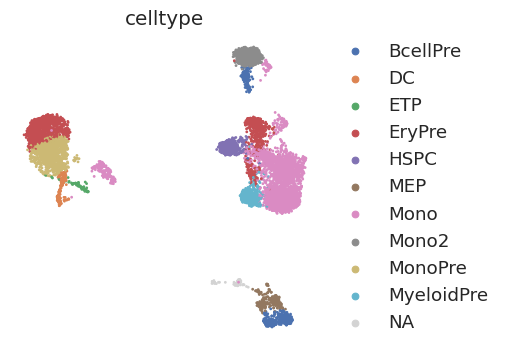

In [15]:
# Plot the umap colored by cell types
sc.pl.umap(ad, color="celltype", frameon=False)

The above function uses the `ad.obms['X_umap']` to plot the umap. If you want to use an alternative visualization, you can use the `sc.pl.scatter` function

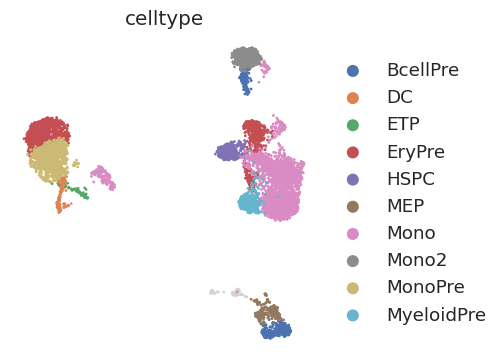

In [16]:
# Plot the umap colored by cell types
sc.pl.scatter(ad, color="celltype", basis="umap", frameon=False)

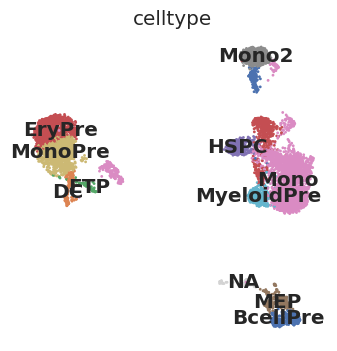

In [17]:
# We can highlight cell-types on the umap itself
sc.pl.umap(ad, color="celltype", legend_loc="on data", frameon=False)

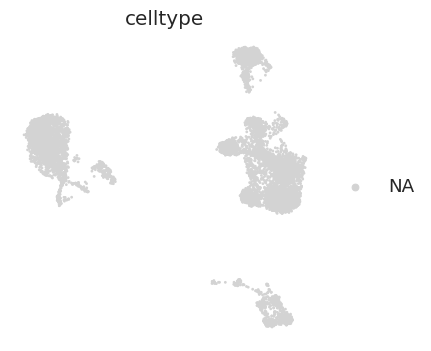

In [18]:
# Or plot specific cell types
sc.pl.umap(ad, color="celltype", groups=["pDC", "B cell precursor"], frameon=False)

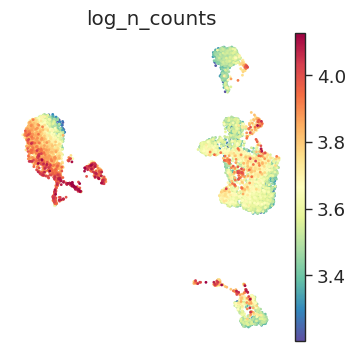

In [19]:
# UMAPs can be colored by continuous values too
sc.pl.umap(ad, color="log_n_counts", frameon=False)

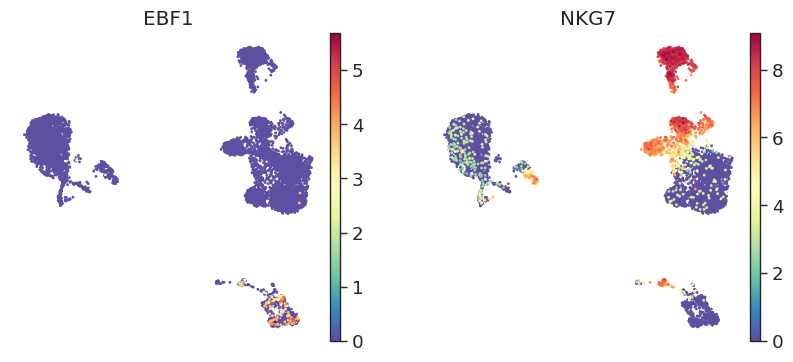

In [20]:
# Or by gene expression values
sc.pl.umap(ad, color=["EBF1", "NKG7"], frameon=False)

# Preprocess

This section will start with raw data and go through the preprocessing and QC

## Load data

In [21]:
data_dir = "../data/"
filename = "pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5"
download_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/" + filename
file_path = os.path.join(data_dir, filename)

ad = sc.read_10x_h5(file_path, backup_url=download_url)
ad.var_names_make_unique()
ad

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test2/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 7865 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

## QC

**Note:** With pandas >=1.3, `sc.pp.calculate_qc_metrics` throws a `ValueError`, should resolve in pandas >=1.4.
See [here](https://github.com/theislab/scanpy/issues/2008) for more details.

In [22]:
ad.var["mt"] = ad.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    ad,
    qc_vars=["mt"],
    inplace=True,
    percent_top=None,
    log1p=False,
)

### Filter cell based on RNA

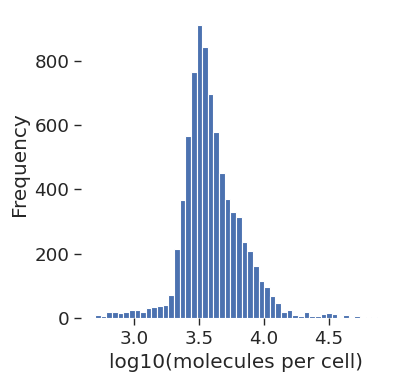

In [23]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs["total_counts"]), 50)
ax.set_xlabel("log10(molecules per cell)")
ax.set_ylabel("Frequency")
plt.show()

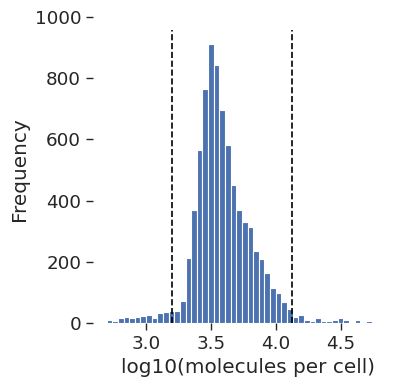

In [24]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells
THRESHOLDS = np.log10(np.percentile((ad.obs["total_counts"]), [3, 98]))

plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs["total_counts"]), 50)
ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color="black", linestyle="--")
ax.set_xlabel("log10(molecules per cell)")
ax.set_ylabel("Frequency")
plt.show()

In [25]:
# Filter cells
use_cells = ad.obs_names[
    (np.log10(ad.obs["total_counts"]) > THRESHOLDS[0])
    & (np.log10(ad.obs["total_counts"]) < THRESHOLDS[1])
]
ad = ad[use_cells, :]

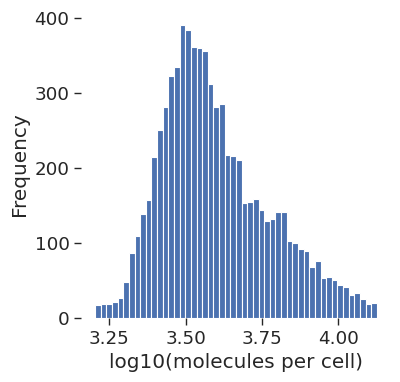

In [26]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs["total_counts"]), 50)
ax.set_xlabel("log10(molecules per cell)")
ax.set_ylabel("Frequency")
plt.show()

### Filter based on mitochondria

In [27]:
ad.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,12,0.001526,99.847425,12.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,5,0.001526,99.936427,12.0
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,42,0.005722,99.465989,45.0
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0


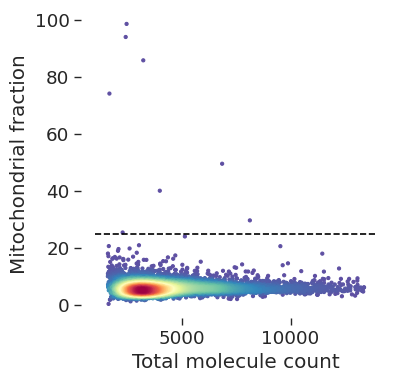

In [28]:
MITO_THRESHOLD = 25
# Mito fraction seems unusually low in this dataset
x, y, dens = palantir.plot.density_2d(ad.obs["total_counts"], ad.obs["pct_counts_mt"])

plt.figure()
ax = plt.gca()
ax.scatter(x, y, c=dens, s=5)
ax.hlines(
    MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color="black", linestyle="--"
)

plt.xlabel("Total molecule count")
plt.ylabel("Mitochondrial fraction")
plt.show()

In [29]:
ad = ad[ad.obs["pct_counts_mt"] < MITO_THRESHOLD, :]

In [30]:
ad

View of AnnData object with n_obs × n_vars = 7462 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Analysis

In [31]:
# Filter genes
sc.pp.filter_genes(ad, min_cells=50)

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [32]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [33]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor="cell_ranger", n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [34]:
# PCA
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)
ad
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [35]:
# UMAP and Leiden - requires the computation of nearest neighbors
sc.pp.neighbors(ad, use_rep="X_pca")
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
# Diffusion maps
dm_res = palantir.utils.run_diffusion_maps(
    pd.DataFrame(ad.obsm["X_pca"], index=ad.obs_names)
)
ad.obsp["DM_Kernel"] = dm_res["kernel"]
ad.obsm["DM_EigenVectors"] = dm_res["EigenVectors"].values
ad.uns["DMEigenValues"] = dm_res["EigenValues"].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [37]:
# Force directed layout
ad.obsm["X_FDL"] = harmony.plot.force_directed_layout(dm_res["kernel"]).values

100%|██████████| 500/500 [00:46<00:00, 10.70it/s]

BarnesHut Approximation  took  22.71  seconds
Repulsion forces  took  21.47  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  1.00  seconds
AdjustSpeedAndApplyForces step  took  0.64  seconds


In [38]:
# Phenograph
ad.obs["phenograph"], _, _ = phenograph.cluster(ad.obsm["X_pca"])
ad.obs["phenograph"] = ad.obs["phenograph"].astype(str)
ad

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22960400581359863 seconds
Jaccard graph constructed in 1.3902037143707275 seconds
Wrote graph to binary file in 0.14052844047546387 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.872257
Louvain completed 21 runs in 2.2493255138397217 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.089659690856934 seconds


AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_FDL'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [39]:
# Imputation
ad.obsm["MAGIC_imputed_data"] = np.array(impute_data(dm_res, ad))

# Doublet Detection with Scrublet

[Scrublet](https://github.com/AllonKleinLab/scrublet) is used to detect doublets in single-cell RNA-sequencing data. Doublets, which are artefacts caused by two or more cells being misidentified as one, can distort downstream analyses. 

Scrublet should be run per sample, before normalization, as it calculates a 'doublet score' for each cell based on simulated artificial doublets. These scores can then be used to filter out doublets in subsequent steps.

Doublet scores can be added to the AnnData object for use in downstream filtering.

In [40]:
sc.external.pp.scrublet(ad)

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 59.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


In [41]:
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues', 'scrublet'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_FDL', 'MAGIC_imputed_data'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

# Visualize results

In [42]:
ad.obs["log_n_counts"] = np.log10(ad.obs["total_counts"])
%matplotlib inline

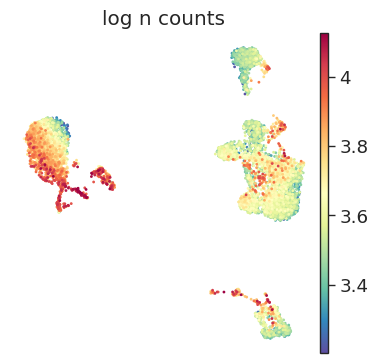

In [43]:
sc.pl.scatter(ad, basis="umap", color="log_n_counts", frameon=False)

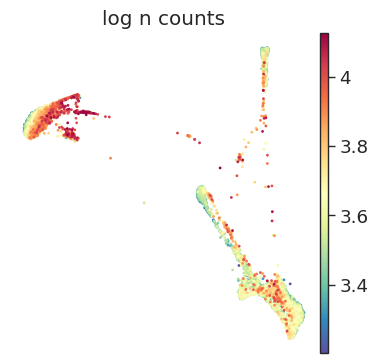

In [44]:
sc.pl.scatter(ad, basis="FDL", color="log_n_counts", frameon=False)

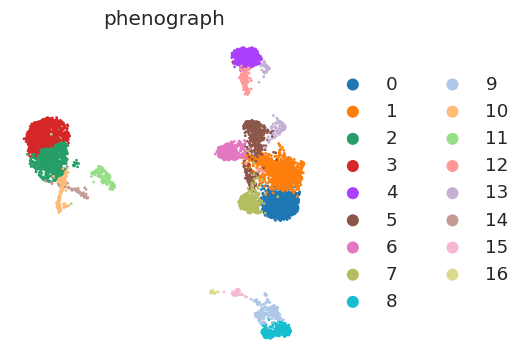

In [45]:
sc.pl.scatter(ad, basis="umap", color=["phenograph"], frameon=False)

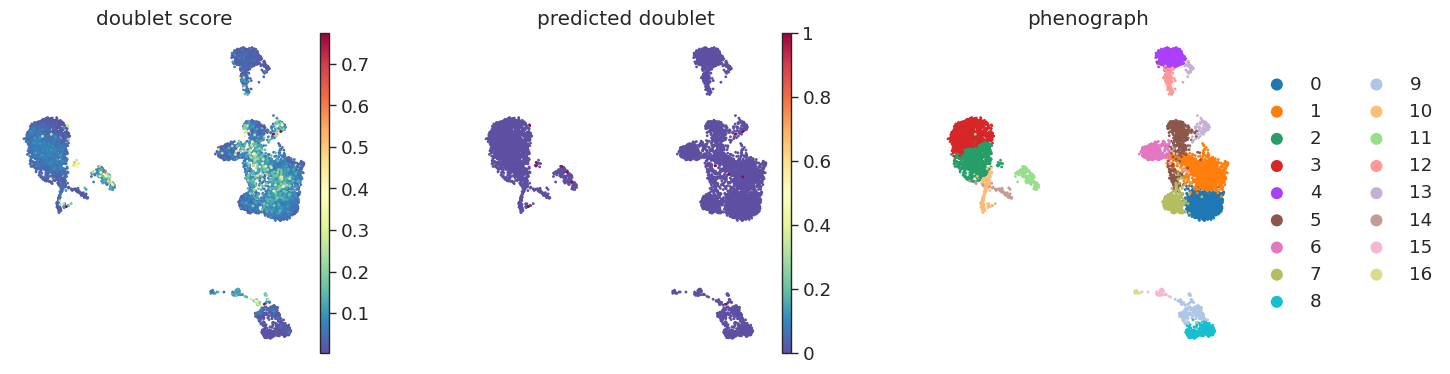

In [46]:
# Doublet scores
sc.pl.scatter(
    ad,
    basis="umap",
    color=["doublet_score", "predicted_doublet", "phenograph"],
    frameon=False,
)

# Celltype annotation

In [47]:
genes = pd.Series([
    "CD34",  # Early Progenitor
    "GATA1",  # Erythroid
    "PAX5", "MS4A1", "MME",  # B-Cell Trajectory
    "CD14",  # Monocytes
    "CD3D", "CD8A", "CD4",  # TCells,
    "FCGR3A",  #'CD16',
    "LEF1", "NKG7", "TREM1", "LYZ", "CD19", "IRF8", "IRF4",
    "ITGA2B",  # CD41,
    "NCAM1",  # CD56,
    "CCR7",  # Memory T cell
])
genes = genes[genes.isin(ad.var_names)]

In [48]:
imp_df = pd.DataFrame(
    ad.obsm["MAGIC_imputed_data"], index=ad.obs_names, columns=ad.var_names
)

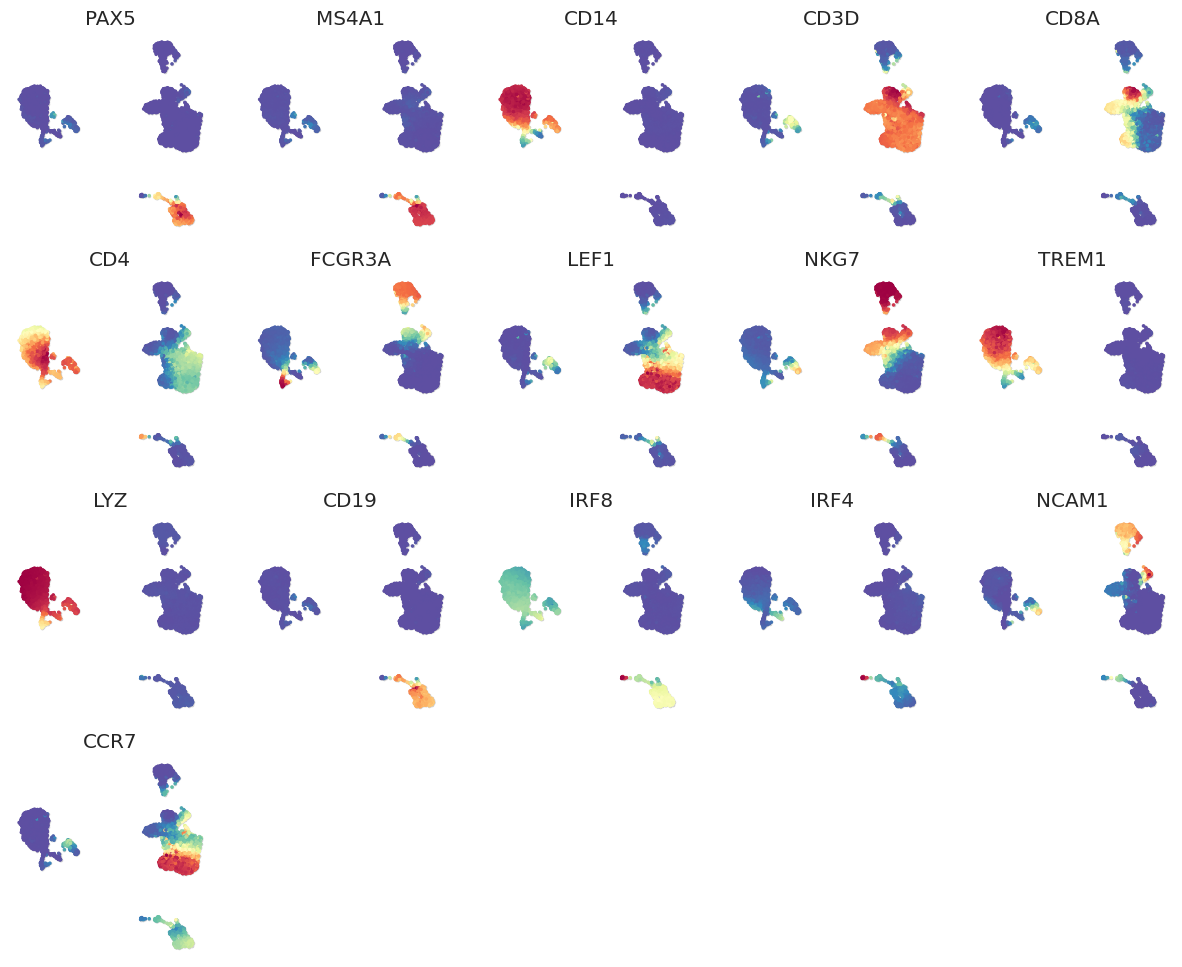

In [49]:
palantir.plot.plot_gene_expression(
    imp_df,
    pd.DataFrame(ad.obsm["X_umap"], index=ad.obs_names, columns=["x", "y"]),
    genes,
)

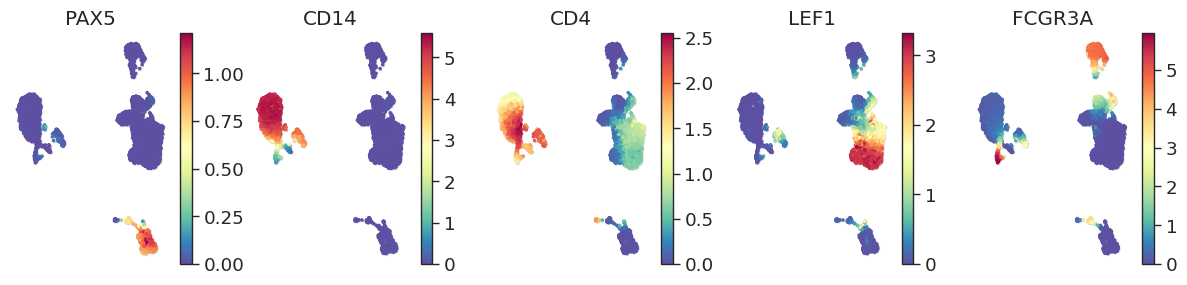

In [50]:
palantir.plot.plot_gene_expression(
    imp_df,
    pd.DataFrame(ad.obsm["X_umap"], index=ad.obs_names, columns=["x", "y"]),
    ["PAX5", "CD14", "CD4", "LEF1", "FCGR3A"],
    plot_scale=True,
)

/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test2/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test2/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


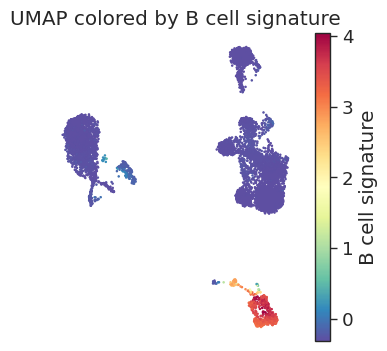

In [51]:
# Define B cell gene signatures
bcell_signature = ["PAX5", "MS4A1"]

# Import the necessary function for Z-transform expression
from sklearn.preprocessing import scale

# Standardize gene expression data by removing the mean and scaling to unit variance
scaled_expression = pd.DataFrame(
    scale(imp_df[bcell_signature]), 
    index=imp_df.index, 
    columns=bcell_signature
)

# Aggregate the standardized expressions by computing their mean
aggregated_expression = scaled_expression.mean(axis=1)

# Create a scatter plot of the UMAP with color-coded B cell signature
fig, ax = plt.subplots()
scatter = ax.scatter(ad.obsm["X_umap"][:, 0], ad.obsm["X_umap"][:, 1], s=1, c=aggregated_expression)
ax.axis('off')
fig.colorbar(scatter, ax=ax, label='B cell signature')
ax.set_title("UMAP colored by B cell signature")
plt.show()

In [52]:
ad.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,leiden,phenograph,doublet_score,predicted_doublet,log_n_counts
AAACCCAAGATTGTGA-1,2194,6160.0,523.0,8.490260,6138.0,2,3,0.062667,False,3.789581
AAACCCACATCGGTTA-1,2093,6713.0,415.0,6.182034,6706.0,4,3,0.054612,False,3.826917
AAACCCAGTACCGCGT-1,1518,3637.0,287.0,7.891119,3627.0,2,2,0.062667,False,3.560743
AAACCCAGTCGTCATA-1,1240,2611.0,156.0,5.974722,2598.0,3,4,0.026025,False,3.416807
AAACCCAGTCTACACA-1,2022,5035.0,477.0,9.473684,5023.0,2,2,0.023100,False,3.701999
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTCAAGTC-1,2178,5830.0,323.0,5.540309,5812.0,13,15,0.121145,False,3.765669
TTTGTTGGTTGCATGT-1,1256,4096.0,256.0,6.250000,4086.0,6,0,0.038443,False,3.612360
TTTGTTGGTTGCGGCT-1,1907,5524.0,574.0,10.391021,5514.0,2,2,0.088260,False,3.742254
TTTGTTGTCGAGTGAG-1,1605,4039.0,271.0,6.709581,4028.0,7,6,0.038443,False,3.606274


In [53]:
# Mapping of phenograph values to cell types
phenograph_to_celltype = {
    "0": "Mono",
    "1": "Mono",
    "2": "MonoPre",
    "3": "EryPre",
    "4": "Mono2",
    "5": "EryPre",
    "6": "HSPC",
    "7": "MyeloidPre",
    "8": "BcellPre",
    "9": "MEP",
    "10": "DC",
    "11": "Mono",
    "12": "BcellPre",
    "13": "Mono",
    "14": "ETP",
}

# Assign cell type to each cell using the mapping
ad.obs["celltype"] = ad.obs["phenograph"].map(phenograph_to_celltype)

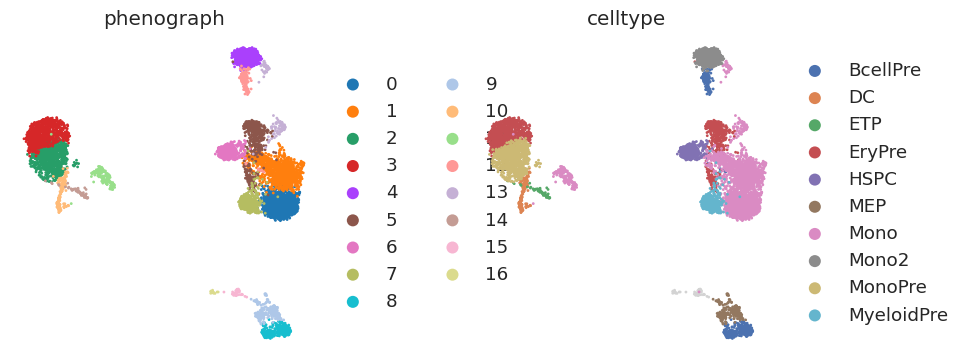

In [54]:
sc.pl.scatter(ad, basis="umap", color=["phenograph", "celltype"], frameon=False)

# Save

In [55]:
ad.write('../data/pbmc_10x_rna_processed.h5ad')